In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

This BDT training only uses 3 features.  
Will compare the shape of Forward/Central distribution.  

# Train

In [2]:
file = "/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EB3/pkls/small_sample_periodA.pkl"

small_sample = pd.read_pickle(file)
small_sample = small_sample.drop(columns=['jet_pt','jet_eta'])
small_sample_array = small_sample.to_numpy()

assert small_sample_array.shape == (200000, 10 -2)

In [3]:
columns = [*small_sample.columns]

In [4]:
columns

['jet_nTracks',
 'jet_trackWidth',
 'jet_trackC1',
 'jet_trackBDT',
 'jet_PartonTruthLabelID',
 'total_weight',
 'flat_weight',
 'target']

In [5]:
n_features = 3
flat_pt_weight_idx = columns.index('flat_weight')
phys_weight_idx = columns.index('total_weight')

In [6]:
X = small_sample_array[:, :-1]
y = small_sample_array[:, -1]

In [7]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=0.001,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=1000,
                         learning_rate=0.1)

bdt.fit(X_train[:, :n_features], y_train, sample_weight=X_train[:,phys_weight_idx])


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=1000)

In [10]:
y_test_decisions = bdt.decision_function(X_test[:, :n_features])

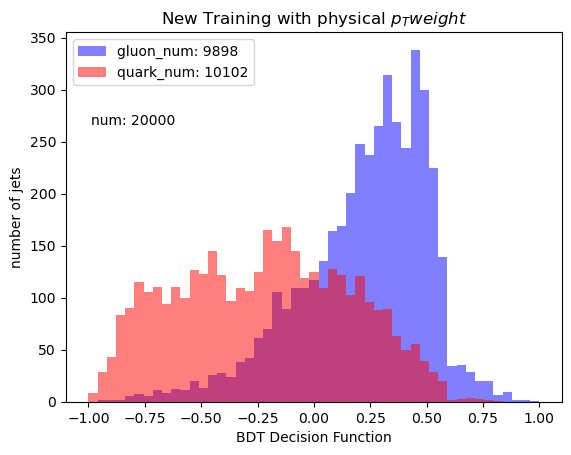

In [11]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test[y_test_gluon_id][:, phys_weight_idx], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test[y_test_quark_id][:, phys_weight_idx], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with physical $p_{T} weight$")
plt.savefig("New_Training_flatpt.png", dpi=300)
plt.show()


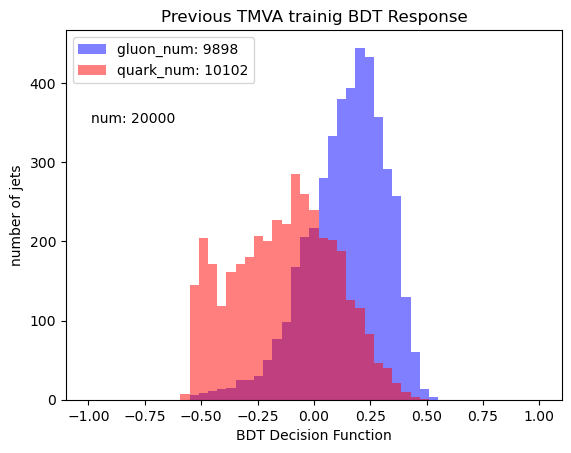

In [12]:
bins_scores_tmva = np.linspace(-1, 1, 50)
plt.hist(X_test[:,-4][y_test_gluon_id], bins_scores_tmva, weights=X_test[:,phys_weight_idx][y_test_gluon_id], alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue')
plt.hist(X_test[:,-4][y_test_quark_id], bins_scores_tmva, weights=X_test[:,phys_weight_idx][y_test_quark_id], alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title("Previous TMVA trainig BDT Response")
plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


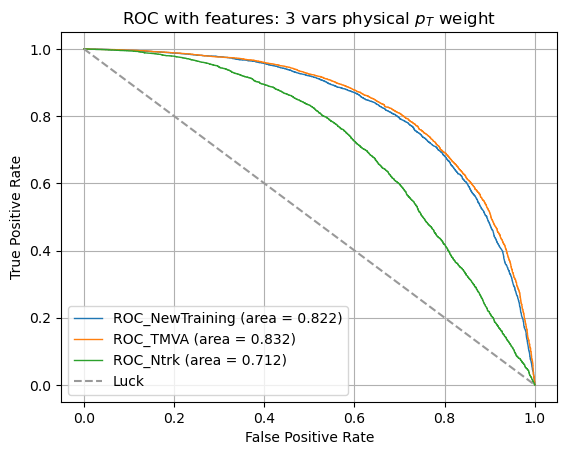

In [17]:
Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test[:,3] , y_ntrk=X_test[:,1], X_weight=X_test[:, phys_weight_idx], features=" 3 vars")

In [18]:
import pickle
filename = './bat_3vars_notune_160k.model'
pickle.dump(bdt, open(filename, 'wb'))

# Overtraining test

In [19]:
y_test_decisions = bdt.decision_function(X_test[:, :n_features])
y_train_decisions = bdt.decision_function(X_train[:, :n_features])

In [20]:
y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)

In [21]:
bins=np.linspace(-1, 1, 50)
plt.hist(decisions[0], weights = X_train[:,7][np.where(y_train==1)],
            color='b', alpha=0.5, bins=bins,
            histtype='stepfilled', density=True,
            label='S (train)')
plt.hist(decisions[1], weights = X_train[:,7][np.where(y_train==0)],
            color='r', alpha=0.5,  bins=bins,
            histtype='stepfilled', density=True,
            label='B (train)')

hist, bins = np.histogram(decisions[2], weights=X_test[:,7][np.where(y_test==1)],
                            bins=bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

width = (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S (test)')

hist, bins = np.histogram(decisions[3], weights=X_test[:,7][np.where(y_test==0)],
                            bins=bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='B (test)')

plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")
plt.savefig("overfitting_test.png",dpi=300)

IndexError: index 7 is out of bounds for axis 1 with size 7

# Apply to data with eta label to show Forward/Central

## Read data

In [ ]:
data_path = '/global/cfs/projectdirs/atlas/hrzhao/qgcal/BDT_EPEML/pkls_etalabel/all_JZs_format2.pkl'
with open(data_path, 'rb') as f:
    data = pickle.load(f)

In [ ]:
columns = [*data['JZ4'].columns]
n_features = 4


In [ ]:
empty_list = []
for key, data_JZ in tqdm(data.items()):
    empty_list.append(data_JZ.drop(columns=['event']))


In [ ]:
pd_all = pd.concat(empty_list)

In [ ]:
#FIXME Why the min PartonTruthLabelID is -1? 
np.min(pd_all['jet1_PartonTruthLabelID'])
np.sum(pd_all['jet1_PartonTruthLabelID']==-1) + np.sum(pd_all['jet2_PartonTruthLabelID']==-1)

In [ ]:
pd_array = pd_all.to_numpy()
jets_array = pd_array.reshape((int(len(pd_array)*2), -1))
assert jets_array.shape[-1] == 10 

In [ ]:
jets_array = np.delete(jets_array, 1, 1)
assert jets_array.shape[-1] == 9 

## Read BDT Model

In [ ]:
bdt_path = './models/bdt_model_flat_pt_noeta.model'
with open(bdt_path, 'rb') as f:
    bdt = pickle.load(f)

In [ ]:
bdt

In [ ]:
y_mc16A = bdt.decision_function(jets_array[:, :n_features])

In [ ]:
np.save('y_mc16A.npy', y_mc16A)

## Plot new response

### Inclusive Quark vs Gluon

In [ ]:
bdt_bins = np.linspace(-1, 1, 101)
quark_idx = np.where(jets_array[:, -1] ==0)[0]
gluon_idx = np.where(jets_array[:, -1] ==1)[0]

fig, ax = plt.subplots()
ax.hist(y_mc16A[quark_idx], weights=jets_array[quark_idx,-3], bins=  bdt_bins, alpha = 0.5,label='Quark Jets', density=True)
ax.hist(y_mc16A[gluon_idx], weights=jets_array[gluon_idx,-3], bins=  bdt_bins, alpha = 0.5,label='Gluon Jets', density=True)
ax.legend()
plt.show()

### Quark vs Gluon in pt bins

In [ ]:
label_ptrange = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
pt_binned_jets_idx = np.digitize(jets_array[:,0], bins=label_ptrange)
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    gluon_idx = np.where(jets_at_pt[:, -1] ==1)[0]
    quark_idx = np.where(jets_at_pt[:, -1] ==0)[0]
    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][quark_idx], weights=jets_at_pt[quark_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Quark Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][gluon_idx], weights=jets_at_pt[gluon_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Gluon Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()

### Inclusive Forward vs Central

In [ ]:
forward_idx = np.where(jets_array[:, -2] ==1)[0]
central_idx = np.where(jets_array[:, -2] ==0)[0]
fig, ax = plt.subplots()
ax.hist(y_mc16A[forward_idx], weights=jets_array[forward_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
ax.hist(y_mc16A[central_idx], weights=jets_array[central_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
ax.legend()
plt.plot()

### Forward vs Central in pt bins

In [ ]:
label_ptrange = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
pt_binned_jets_idx = np.digitize(jets_array[:,0], bins=label_ptrange)
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    forward_idx = np.where(jets_at_pt[:, -2] ==1)[0]
    central_idx = np.where(jets_at_pt[:, -2] ==0)[0]
    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx], weights=jets_at_pt[forward_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx], weights=jets_at_pt[central_idx,-3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()

### Forward/Central Q/G components

In [ ]:
for i, pt in enumerate(label_ptrange[:-1]):
    jets_at_pt_idx = np.where(pt_binned_jets_idx-1 == i)
    jets_at_pt = jets_array[jets_at_pt_idx]
    forward_idx = np.where(jets_at_pt[:, -2] ==1)[0]
    central_idx = np.where(jets_at_pt[:, -2] ==0)[0]

    forward_jets = jets_at_pt[forward_idx]
    central_jets = jets_at_pt[central_idx]


    forward_quark_idx = np.where(forward_jets[:, -1] == 0)[0]
    forward_gluon_idx = np.where(forward_jets[:, -1] == 1)[0]
    central_quark_idx = np.where(central_jets[:, -1] == 0)[0]
    central_gluon_idx = np.where(central_jets[:, -1] == 1)[0]

    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx], weights=forward_jets[:, -3], bins =  bdt_bins, alpha = 0.5, label='Forward Jets', density = True)
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx], weights=central_jets[:, -3], bins =  bdt_bins, alpha = 0.5, label='Central Jets', density = True)
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()


    fig, ax = plt.subplots()
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx][forward_quark_idx], weights=forward_jets[:, -3][forward_quark_idx], bins =  bdt_bins, alpha = 0.5, label='Forward Quarks', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][forward_idx][forward_gluon_idx], weights=forward_jets[:, -3][forward_gluon_idx], bins =  bdt_bins, alpha = 0.5, label='Forward Gluons', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx][central_quark_idx], weights=central_jets[:, -3][central_quark_idx], bins =  bdt_bins, alpha = 0.5, label='Central Quarks', density = True, histtype='step')
    ax.hist(y_mc16A[jets_at_pt_idx][central_idx][central_gluon_idx], weights=central_jets[:, -3][central_gluon_idx], bins =  bdt_bins, alpha = 0.5, label='Central Gluons', density = True, histtype='step')
    ax.legend()
    ax.set_title(f"{pt} - {label_ptrange[i+1]} GeV jets")
    plt.plot()
